In [180]:
import pandas as pd
import time
import requests
from bs4 import BeautifulSoup as bs
import numpy as np
from datetime import datetime, timedelta
from progressbar import progressbar
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import random


---

### 데이터 활용 방안

* 각각 IPO 종목의 유사도 측정 및 군집화 등을 통해 향후 주가 흐름 예측

---

### 데이터 수집 원칙

* IPO의 특수성 검토


* 수집 난이도 감안


* 출처의 특성 감안


----

### IPO 주가예측 항목



* 소속시장(F01_시장)




* KONEX 이전상장 여부(F02_코넥스)




* 중국기업 여부(F03_중국)




* 시가총액(F04_시가총액)




* 밴드 괴리도(F05_밴드대비)




* 기관 확약비율(F06_기관확약)




* 최대주주 지분율(F07_최대주주)




* 미확약 유통물량(F08_유통물량)




* 미확약 오버행(F09_미확약오버행)




* 단기 오버행(F10_단기오버행)




* 상장월(F11_상장월)




* 집중도(F12_해당월)





* 직전딜 수익률(F13_직전수익률)




* 기관 경쟁률(F14_기관경쟁률)




* 일반공모 경쟁률(F15_공모경쟁률)




#### 기본데이터 URL에서 수집하기

In [181]:
ipo_url = 'http://210.89.189.240/ipo/jsondata'

In [182]:
df = pd.read_json(ipo_url)

In [183]:
df.to_csv('ipo_data.csv', encoding = 'euckr')

In [184]:
df.columns

Index(['changeoverQuantityRate', 'confirmedOverhangRate',
       'confirmedPublicOfferingPrice', 'demandPredictionDate',
       'distributedQuantityRate', 'employeeAssociation', 'equity',
       'generalApplicant', 'institutionalCompetitionRate',
       'institutionalConfirmRate', 'institutionalInvestors',
       'largestShareholderRate', 'leadManager', 'marketCapitalizationRate',
       'parValue', 'protectionPeriodRate1M', 'protectionPeriodRate1W',
       'protectionPeriodRate1Y', 'protectionPeriodRate2M',
       'protectionPeriodRate2W', 'protectionPeriodRate2Y',
       'protectionPeriodRate3M', 'protectionPeriodRate3W',
       'protectionPeriodRate3Y', 'protectionPeriodRate6M',
       'publicOfferingDesirePrice', 'publicationDate',
       'publicationScheduledStockCount', 'refundDate', 'snum', 'stockCode',
       'stockName', 'subscriptionCompetitionRate', 'subscriptionDate',
       'totalStockCount'],
      dtype='object')

In [185]:
cols = {
    'changeoverQuantityRate' : '지분_주식매수선택권', 
    'confirmedOverhangRate' : '지분_주간사락업',
    'confirmedPublicOfferingPrice': '확정공모가', 
    'demandPredictionDate': '수요예측일',
    'distributedQuantityRate':'지분_미확약유통가능', 
    'employeeAssociation': '주식_우리사주', 
    'equity': '상장전자본금',
    'generalApplicant':'주식_일반공모', 
    'institutionalCompetitionRate':'기관경쟁률',
    'institutionalConfirmRate': '기관확약률', 
    'institutionalInvestors': '주식_기관공모',
    'largestShareholderRate': '지분_최대주주', 
    'leadManager': '상장주간사', 
    'marketCapitalizationRate': '기타',
    'parValue': '액면가', 
    'protectionPeriodRate1M': '락업_1개월', 
    'protectionPeriodRate1W': '락업_1주일',
    'protectionPeriodRate1Y': '락업_1년', 
    'protectionPeriodRate2M': '락업_2개월',
    'protectionPeriodRate2W':'락업_2주', 
    'protectionPeriodRate2Y':'락업_2년',
    'protectionPeriodRate3M':'락업_3개월', 
    'protectionPeriodRate3W':'락업_3주',
    'protectionPeriodRate3Y':'락업_3년', 
    'protectionPeriodRate6M':'락업_6개월',
    'publicOfferingDesirePrice': '공모가밴드', 
    'publicationDate':'상장일',
    'publicationScheduledStockCount': '상장예정주식수', 
    'refundDate': '환불일', 
    'snum': '고유번호', 
    'stockCode': '코드',
    'stockName':'종목명', 
    'subscriptionCompetitionRate': '일반경쟁률', 
    'subscriptionDate': '청약일',
    'totalStockCount':'희석감안주식수'
    }

In [186]:
df = df.rename(columns = cols)

In [187]:
df

,지분_주식매수선택권,지분_주간사락업,확정공모가,수요예측일,지분_미확약유통가능,주식_우리사주,상장전자본금,주식_일반공모,기관경쟁률,기관확약률,...,공모가밴드,상장일,상장예정주식수,환불일,고유번호,코드,종목명,일반경쟁률,청약일,희석감안주식수
0,0.00,NaN,,2019-04-25,0.00,,0.62,"1,600,000",None,NaN,...,"2,000~2,000",,None,2019-05-02,1848,319400,엔에이치기업인수목적14호,,2019-04-30,None
1,0.00,NaN,"2,000",2019-04-12,0.00,,0.40,"800,000",None,NaN,...,"2,000~2,000",,None,2019-04-22,1846,317240,하이제4호기업인수목적,1.89 : 1,2019-04-18,None
2,0.00,NaN,,2019-04-17,0.00,,0.61,"750,000",None,NaN,...,"2,000~2,000",,None,2019-04-25,1845,317320,한화에스비아이기업인수목적,,2019-04-23,None
3,0.00,NaN,"2,000",2019-03-14,0.00,,0.46,"1,000,000",None,NaN,...,"2,000~2,000",2019-03-27,None,2019-03-21,1844,317030,케이비제17호기업인수목적,1.49 : 1,2019-03-19,None
4,0.00,0.77,,2019-05-09,25.62,,57.45,"800,000",None,NaN,...,"3,600~4,000",,"15,610,000",2019-05-16,1841,307930,컴퍼니케이파트너스,,2019-05-14,"15,610,000"
5,4.56,0.32,,2019-05-08,68.15,"150,000",58.61,"300,000",None,NaN,...,"12,000~14,000",,"13,268,034",2019-05-20,1838,253840,수젠텍,,2019-05-16,"13,902,394"
6,0.00,NaN,"2,000",2019-03-05,0.00,,0.55,"820,000",None,NaN,...,"2,000~2,000",2019-03-21,None,2019-03-14,1834,313750,유안타제4호기업인수목적,1.81 : 1,2019-03-12,None
7,0.00,0.61,"12,300",2019-03-06,56.66,"150,000",25.24,"260,000","1,108.03 : 1",NaN,...,"10,100~12,300",2019-03-22,"6,386,000",2019-03-15,1833,099750,이지케어텍,1272.11 : 1,2019-03-13,"6,386,000"
8,0.00,7.14,"48,000",2019-03-14,13.37,"702,000",103.26,"702,000",797.36 : 1,NaN,...,"40,000~44,000",2019-03-28,"21,000,000",2019-03-22,1831,307950,현대오토에버,345.24 : 1,2019-03-20,"21,000,000"
9,0.00,NaN,"2,000",2018-12-13,0.00,,0.10,"700,000",None,NaN,...,"2,000~2,000",2018-12-28,None,2018-12-20,1829,311270,키움제5호기업인수목적,2.04 : 1,2018-12-18,None


### copy() 명령어

In [188]:
work = df.copy()

In [189]:
work = work.set_index('코드')

### 부동산회사, SPAC 등 제외

In [190]:
except_list = [
    '기업인수목적',
    '부동산',
    '스팩',
    'SPAC'
    ] 

In [191]:
work1 = work[work['종목명'].str.contains('기업인수|부동산|스팩|SPAC|리츠')==False]

In [192]:
work1

,지분_주식매수선택권,지분_주간사락업,확정공모가,수요예측일,지분_미확약유통가능,주식_우리사주,상장전자본금,주식_일반공모,기관경쟁률,기관확약률,...,락업_6개월,공모가밴드,상장일,상장예정주식수,환불일,고유번호,종목명,일반경쟁률,청약일,희석감안주식수
코드,,,,,,,,,,,,,,,,,,,,,
307930,0.00,0.77,,2019-05-09,25.62,,57.45,"800,000",None,NaN,...,73.61,"3,600~4,000",,"15,610,000",2019-05-16,1841,컴퍼니케이파트너스,,2019-05-14,"15,610,000"
253840,4.56,0.32,,2019-05-08,68.15,"150,000",58.61,"300,000",None,NaN,...,0.00,"12,000~14,000",,"13,268,034",2019-05-20,1838,수젠텍,,2019-05-16,"13,902,394"
099750,0.00,0.61,"12,300",2019-03-06,56.66,"150,000",25.24,"260,000","1,108.03 : 1",NaN,...,3.42,"10,100~12,300",2019-03-22,"6,386,000",2019-03-15,1833,이지케어텍,1272.11 : 1,2019-03-13,"6,386,000"
307950,0.00,7.14,"48,000",2019-03-14,13.37,"702,000",103.26,"702,000",797.36 : 1,NaN,...,76.15,"40,000~44,000",2019-03-28,"21,000,000",2019-03-22,1831,현대오토에버,345.24 : 1,2019-03-20,"21,000,000"
228760,0.00,34.05,"27,000",2019-03-12,37.94,"120,000",79.75,"800,000",372.39 : 1,NaN,...,9.73,"17,000~25,000",2019-03-27,"19,986,215",2019-03-21,1826,지노믹트리,13.10 : 1,2019-03-19,"19,986,215"
299660,3.23,12.06,"33,000",2019-01-30,46.51,"9,270",41.05,"240,000",778.77 : 1,NaN,...,0.00,"25,000~31,000",2019-02-20,"9,446,889",2019-02-14,1821,셀리드,818.83 : 1,2019-02-12,"9,761,889"
278280,0.00,0.00,"40,000",2019-01-22,35.68,"250,000",40.00,"500,000",891.09 : 1,NaN,...,60.91,"35,000~40,000",2019-02-11,"10,000,000",2019-01-31,1819,천보,426.09 : 1,2019-01-29,"10,000,000"
263050,8.69,3.72,"50,000",2018-12-11,36.61,"43,620",32.58,"145,400",597.20 : 1,NaN,...,0.00,"38,000~50,000",2018-12-24,"7,263,578",2018-12-18,1812,유틸렉스,322.96 : 1,2018-12-14,"7,955,056"
125210,0.00,2.40,"9,900",2019-03-13,35.72,"206,400",65.47,"825,600",164.22 : 1,3.05,...,0.00,"8,800~9,900",2019-03-29,"16,496,790",2019-03-22,1811,아모그린텍,22.13 : 1,2019-03-20,"16,496,790"


### 상장일이 2014년 이후인 종목& 오늘 이전인 종목만 검색

* 상장 철회 종목이 자동으로 걸러질 수 있음

In [193]:
today = (datetime.utcnow()+timedelta(hours=9)).strftime('%Y-%m-%d')

In [194]:
work2 = work1[(work1['상장일'] > '2014-01-01') & (work1['상장일'] < today)]

In [195]:
work2

,지분_주식매수선택권,지분_주간사락업,확정공모가,수요예측일,지분_미확약유통가능,주식_우리사주,상장전자본금,주식_일반공모,기관경쟁률,기관확약률,...,락업_6개월,공모가밴드,상장일,상장예정주식수,환불일,고유번호,종목명,일반경쟁률,청약일,희석감안주식수
코드,,,,,,,,,,,,,,,,,,,,,
099750,0.00,0.61,"12,300",2019-03-06,56.66,"150,000",25.24,"260,000","1,108.03 : 1",NaN,...,3.42,"10,100~12,300",2019-03-22,"6,386,000",2019-03-15,1833,이지케어텍,1272.11 : 1,2019-03-13,"6,386,000"
307950,0.00,7.14,"48,000",2019-03-14,13.37,"702,000",103.26,"702,000",797.36 : 1,NaN,...,76.15,"40,000~44,000",2019-03-28,"21,000,000",2019-03-22,1831,현대오토에버,345.24 : 1,2019-03-20,"21,000,000"
228760,0.00,34.05,"27,000",2019-03-12,37.94,"120,000",79.75,"800,000",372.39 : 1,NaN,...,9.73,"17,000~25,000",2019-03-27,"19,986,215",2019-03-21,1826,지노믹트리,13.10 : 1,2019-03-19,"19,986,215"
299660,3.23,12.06,"33,000",2019-01-30,46.51,"9,270",41.05,"240,000",778.77 : 1,NaN,...,0.00,"25,000~31,000",2019-02-20,"9,446,889",2019-02-14,1821,셀리드,818.83 : 1,2019-02-12,"9,761,889"
278280,0.00,0.00,"40,000",2019-01-22,35.68,"250,000",40.00,"500,000",891.09 : 1,NaN,...,60.91,"35,000~40,000",2019-02-11,"10,000,000",2019-01-31,1819,천보,426.09 : 1,2019-01-29,"10,000,000"
263050,8.69,3.72,"50,000",2018-12-11,36.61,"43,620",32.58,"145,400",597.20 : 1,NaN,...,0.00,"38,000~50,000",2018-12-24,"7,263,578",2018-12-18,1812,유틸렉스,322.96 : 1,2018-12-14,"7,955,056"
125210,0.00,2.40,"9,900",2019-03-13,35.72,"206,400",65.47,"825,600",164.22 : 1,3.05,...,0.00,"8,800~9,900",2019-03-29,"16,496,790",2019-03-22,1811,아모그린텍,22.13 : 1,2019-03-20,"16,496,790"
238200,0.00,12.43,"18,000",2018-12-12,44.45,"19,400",18.34,"82,001",74.62 : 1,NaN,...,0.00,"22,100~28,700",2018-12-26,"4,090,000",2018-12-19,1810,비피도,159.97 : 1,2018-12-18,"4,090,000"
298690,0.00,0.00,"3,600",2018-12-14,53.62,"1,041,400",500.00,"1,041,400",23.89 : 1,0.00,...,44.38,"3,600~4,000",2018-12-27,"52,070,000",2018-12-21,1809,에어부산,36.50 : 1,2018-12-19,"52,070,000"


## 주요 항목 입력

### 소속시장(F01_시장) 

1: KOSPI


0 : KOSDAQ

In [196]:
mdf = pd.DataFrame()
for i in range(1,11) :
    url = "http://www.pstock.co.kr/2005pstock/gongmo/gongmoset/gongmo_menu2_1_list.asp?page=" + str(i)
    df = pd.read_html(url)[19]
    mdf = mdf.append(df)

In [197]:
kospi_list = list(mdf[mdf[0].str[-3:] == "(유)"][0].str[:-3])

In [198]:
kospi_list

['현대오토에버',
 '한국리테일홈플러스제1호위탁관리리츠',
 '드림텍',
 '에어부산',
 '아시아나IDT',
 '씨제이씨지브이베트남',
 '프라코',
 '하나제약',
 '에이치디씨아이서비스',
 '우진아이엔에스',
 '티웨이항공',
 '롯데정보통신',
 '신한알파리츠',
 '이리츠코크렙기업구조조정부동산투자회사',
 'SK루브리컨츠',
 '애경산업',
 '진에어',
 '동양피스톤',
 '삼양패키징',
 '테이팩스',
 '넷마블게임즈',
 'ING생명보험',
 '덴티움',
 '호전실업',
 '핸즈코퍼레이션',
 '두산밥캣',
 '삼성바이오로직스',
 '제이더블유생명과학',
 '화승엔터프라이즈',
 '엘에스전선아시아',
 '까사미아',
 '두올',
 '호텔롯데',
 '한국자산신탁',
 '해성디에스',
 '용평리조트',
 '해태제과식품',
 '대림씨엔에스',
 '제이에스코퍼레이션',
 '코리아오토글라스',
 '잇츠스킨',
 '서울바이오시스',
 'KIS정보통신',
 '세진중공업',
 '태진인터내셔날',
 '금호에이치티',
 '제주항공',
 '엘아이지넥스원',
 '동일제강',
 '아이콘트롤스',
 '에이제이네트웍스',
 '이노션',
 '토니모리',
 '미래에셋생명',
 '경보제약',
 '에스케이디앤디']

In [199]:
work2.loc[work2['종목명'].isin(kospi_list) == True, '종목명']

코드
307950       현대오토에버
298690         에어부산
192650          드림텍
293480         하나제약
267850      아시아나IDT
010400      우진아이엔에스
091810        티웨이항공
286940       롯데정보통신
018250         애경산업
272450          진에어
272550        삼양패키징
092780        동양피스톤
055490         테이팩스
079440      ING생명보험
251270       넷마블게임즈
143210      핸즈코퍼레이션
207940     삼성바이오로직스
241560         두산밥캣
241590     화승엔터프라이즈
111110         호전실업
234080    제이더블유생명과학
229640     엘에스전선아시아
123890       한국자산신탁
195870        해성디에스
101530       해태제과식품
070960        용평리조트
004440       대림씨엔에스
226320         잇츠스킨
194370    제이에스코퍼레이션
152330     코리아오토글라스
089590         제주항공
214330       금호에이치티
039570       아이콘트롤스
079550      엘아이지넥스원
075580        세진중공업
002690         동일제강
095570     에이제이네트웍스
085620       미래에셋생명
214420         토니모리
214320          이노션
214390         경보제약
210980      에스케이디앤디
145720          덴티움
Name: 종목명, dtype: object

#### 시장 구분 입력

In [200]:
work2.loc[work2['종목명'].isin(kospi_list) == True, 'F01_시장구분'] = 5
work2.loc[work2['종목명'].isin(kospi_list) == False, 'F01_시장구분'] = 0
work2.loc[work2['종목명'] == 'NS쇼핑', 'F01_시장구분'] = 5
work2.loc[work2['종목명'] == 'BGF리테일', 'F01_시장구분'] = 5

C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\admin\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [201]:
work2[work2['종목명'] == 'BGF리테일']

,지분_주식매수선택권,지분_주간사락업,확정공모가,수요예측일,지분_미확약유통가능,주식_우리사주,상장전자본금,주식_일반공모,기관경쟁률,기관확약률,...,공모가밴드,상장일,상장예정주식수,환불일,고유번호,종목명,일반경쟁률,청약일,희석감안주식수,F01_시장구분
코드,,,,,,,,,,,,,,,,,,,,,
027410,0.0,0.0,"41,000",2014-04-25,29.14,"1,232,006",246.40,"1,232,006",337.13 : 1,27.58,...,"41,000~46,000",2014-05-19,"24,640,080",2014-05-12,1290,BGF리테일,181.30 : 1,2014-05-08,"24,640,080",5.0


## KONEX 이전상장 여부(F02_코넥스)


1 : KONEX 이전상장
    

0 : 해당없음

In [202]:
konex_list = [
    '아시아종묘',
    '세원',
    '비디아이',
    '링크제니시스',
    '엔지켐생명과학',
    '오스테오닉',
    '케이피에스',
    '이엘피',
    '현성바이탈',
    '유니온커뮤니티',
    '퓨쳐켐',
    '엘앤케이바이오',
    '핸디소프트',
    '옵토팩',
    '바이오리더스',
    '알엔투테크놀로지',
    '씨트리',
    '예스티',
    '엠지메드',
    '리드',
    '매직마이크로',
    '아이진',
    '엑시콘',
    '칩스앤미디어',
    '베셀',
    '아이티센',
    '하이로닉',
    '랩지노믹스',
    '테라셈',
    '메디아나',
    '아진엑스텍',
    '지노믹트리'
    ]
len(konex_list)

32

In [203]:
k = work2.loc[work2['종목명'].isin(konex_list) == True]['종목명'].values

In [204]:
len(k)

31

In [205]:
for i in konex_list :
    if i not in k :
        print(i)

엘앤케이바이오


#### 시장구분 입력

In [206]:
work2.loc[work2['종목명'].isin(konex_list) == True, 'F02_코넥스'] = 5
work2.loc[work2['종목명'].isin(konex_list) == False, 'F02_코넥스'] = 0
work2.loc[work2['종목명'] == '엘앤케이바이오메드', 'F02_코넥스'] = 5

## 중국기업 여부(F03_중국)


1 : 중국기업
    

0 : 해당없음

In [207]:
china_list = [
    '컬러레이홀딩스',
    '오가닉티코스메틱',
    '그레이트리치과기', 
    '골든센츄리',
    '헝셩그룹',
    '로스웰',
    '차이나크리스탈신소재'
]
len(china_list)

7

In [208]:
len(work2.loc[work2['종목명'].isin(china_list) == True]['종목명'].values)

7

In [209]:
work2.loc[work2['종목명'].isin(china_list) == True, 'F03_중국'] = 1
work2.loc[work2['종목명'].isin(china_list) == False, 'F03_중국'] = 0

## 시가총액(F04_시가총액)


In [210]:
def str_to_int(text) :
    return int(text.replace(",",""))

In [211]:
work2.loc['950170', '희석감안주식수'] = '35,005,517'
work2.loc['950170', '지분_미확약유통가능'] = 34.3
work2.loc['950170', '지분_최대주주'] = 59.0
work2.loc['950170', '락업_2주'] = 0.8
work2.loc['950170', '락업_1개월'] = 4.5

In [212]:
work2 = work2.drop('950160')

In [213]:
work2['확정공모가'] = work2['확정공모가'].apply(str_to_int)
work2['희석감안주식수']= work2['희석감안주식수'].apply(str_to_int)

In [214]:
work2['시가총액'] = (work2['확정공모가'] * work2['희석감안주식수'])/100000000

In [215]:
work2['시가총액']

코드
099750      785.478000
307950    10080.000000
228760     5396.278050
299660     3221.423370
278280     4000.000000
263050     3977.528000
125210     1633.182210
238200      736.200000
298690     1874.520000
299900     1128.880610
298380     6795.502500
290550      609.118642
100790     1390.824675
270870     1319.512180
100590      900.579600
302430     1254.528080
027360     1780.710750
179290     1369.060110
227100      274.256410
192650     4065.701640
263020      465.792120
299910     2819.344850
117730      924.708640
053580     1777.722440
290660     1343.049950
290670     1002.106000
128540      616.509600
268600     2077.026750
290120      326.520000
290650     1772.239680
              ...     
112610     7519.286025
149980     1466.800290
124500      349.730625
196490      398.883276
065660     1792.712400
143540      279.247400
191420      499.885695
182690      418.990200
189860      315.210350
194480     6388.090000
192440     1711.722100
194510      620.100000
192410  

(array([124.,  95.,  42.,  19.,  14.,   6.,   6.,   1.,   2.,   4.,   1.,
          2.]),
 array([    0.        ,   833.33333333,  1666.66666667,  2500.        ,
         3333.33333333,  4166.66666667,  5000.        ,  5833.33333333,
         6666.66666667,  7500.        ,  8333.33333333,  9166.66666667,
        10000.        ]),
 <a list of 12 Patch objects>)

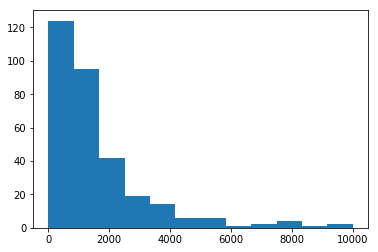

In [216]:
plt.hist(work2['시가총액'], bins =12, range = (0,10000))

In [217]:
work2.loc[work2['시가총액']<900, 'F04_시가총액'] = 1
work2.loc[(work2['시가총액']>=900) & (work2['시가총액']<2000), 'F04_시가총액'] = 2
work2.loc[(work2['시가총액']>=2000) & (work2['시가총액']<4000), 'F04_시가총액'] = 3
work2.loc[(work2['시가총액']>=4000) & (work2['시가총액']<10000), 'F04_시가총액'] = 4
work2.loc[(work2['시가총액']>=10000), 'F04_시가총액'] = 5


In [218]:
work2['F04_시가총액'].value_counts()

1.0    131
2.0    108
3.0     50
4.0     27
5.0     20
Name: F04_시가총액, dtype: int64

## 밴드 괴리도(F05_밴드대비)

In [219]:
def take_upper_band(band) :
    return int(band.split("~")[1].replace(",","").replace(".", ""))

In [220]:
def take_lower_band(band) :
    return int(band.split("~")[0].replace(",","").replace(".", ""))

In [221]:
work2['상단'] = work2['공모가밴드'].apply(take_upper_band)
work2['하단'] = work2['공모가밴드'].apply(take_lower_band)


In [222]:
work2.loc[work2['확정공모가'] > work2['상단'], 'F05_밴드대비'] = 5
work2.loc[work2['확정공모가'] == work2['상단'], 'F05_밴드대비'] = 4
work2.loc[(work2['확정공모가'] < work2['상단']) & (work2['확정공모가'] > work2['하단']), 'F05_밴드대비'] = 3
work2.loc[work2['확정공모가'] == work2['하단'], 'F05_밴드대비'] = 2
work2.loc[work2['확정공모가'] < work2['하단'], 'F05_밴드대비'] = 1


### value_counts

In [223]:
work2['F05_밴드대비'].value_counts()

4.0    123
5.0     72
1.0     54
2.0     47
3.0     40
Name: F05_밴드대비, dtype: int64

## 기관 확약비율(F06_기관확약)

In [224]:
work2[['종목명','기관확약률']]

,종목명,기관확약률
코드,,
099750,이지케어텍,NaN
307950,현대오토에버,NaN
228760,지노믹트리,NaN
299660,셀리드,NaN
278280,천보,NaN
263050,유틸렉스,NaN
125210,아모그린텍,3.05
238200,비피도,NaN
298690,에어부산,0.00


#### 기존데이터에 문제 있음.

38 사이트에서 가져오기로 함

In [225]:
inv_df = pd.DataFrame()
for i in progressbar(range(1,25)) :
    url = "http://www.38.co.kr/html/fund/index.htm?o=r1&page=" + str(i)
    idf = pd.read_html(url)
    idd = idf[15]
    inv_df = inv_df.append(idd[['기업명','의무보유확약']].dropna())
    

100% (24 of 24) |########################| Elapsed Time: 0:00:06 Time:  0:00:06


In [226]:
inv_df = inv_df[inv_df['기업명'].str.len() < 20].iloc[1:]

In [227]:
inv_df

,기업명,의무보유확약
1,하이스팩4호,-
2,현대오토에버,57.79%
3,케이비스팩17호,-
4,아모그린텍,3.05%
5,지노믹트리,22.80%
6,이지케어텍,40.25%
7,유안타스팩4호,-
8,미래에셋벤처투자,3.70%
9,드림텍,0.80%
10,에코프로비엠,45.04%


In [228]:
for i in inv_df['기업명'].tolist() :
    if '아주' in i :
        print(i)

아주IB투자


In [229]:
inv_df.to_csv("inv.csv")

In [230]:
def make_name(text) :
    return text.split("(")[0]

In [231]:
inv_df['기업명'] = inv_df['기업명'].apply(make_name)

In [232]:
inv_df = inv_df.replace('제이티씨', 'JTC')
inv_df = inv_df.replace('컬러레이', '컬러레이홀딩스')
inv_df = inv_df.replace('엘앤케이바이오', '엘앤케이바이오메드')
inv_df = inv_df.replace('금세기차륜', '골든센츄리')
inv_df = inv_df.replace('미래에셋생명보험', '미래에셋생명')
inv_df = inv_df.replace('아시아경제신문사', '아시아경제')
inv_df = inv_df.replace('에프엔씨엔터테인먼트', 'FNC엔터테인먼트')
inv_df = inv_df.replace('아주IB투자', '아주아이비투자')


#inv_df = inv_df.replace('에이치엘사이언스(구.건강사랑)', '에이치엘사이언스')
#inv_df = inv_df.replace('수산아이앤티(구.플러스기술)', '수산아이앤티')
#inv_df = inv_df.replace('대유위니아(구.위니아만도)', '대유위니아')
#inv_df = inv_df.replace('제일모직(구.삼성에버랜드)', '제일모직')
#inv_df = inv_df.replace('디티앤씨(구.디지털이엠씨)', '디티앤씨')
#inv_df = inv_df.replace('NS쇼핑(구.농수산홈쇼핑)', 'NS쇼핑')

In [233]:
work2 = work2.replace("쿠쿠전자 ", "쿠쿠전자")

In [234]:
inv_list = list(inv_df['기업명'].values)

In [235]:
work2

,지분_주식매수선택권,지분_주간사락업,확정공모가,수요예측일,지분_미확약유통가능,주식_우리사주,상장전자본금,주식_일반공모,기관경쟁률,기관확약률,...,청약일,희석감안주식수,F01_시장구분,F02_코넥스,F03_중국,시가총액,F04_시가총액,상단,하단,F05_밴드대비
코드,,,,,,,,,,,,,,,,,,,,,
099750,0.00,0.61,12300,2019-03-06,56.66,"150,000",25.24,"260,000","1,108.03 : 1",NaN,...,2019-03-13,6386000,0.0,0.0,0.0,785.478000,1.0,12300,10100,4.0
307950,0.00,7.14,48000,2019-03-14,13.37,"702,000",103.26,"702,000",797.36 : 1,NaN,...,2019-03-20,21000000,5.0,0.0,0.0,10080.000000,5.0,44000,40000,5.0
228760,0.00,34.05,27000,2019-03-12,37.94,"120,000",79.75,"800,000",372.39 : 1,NaN,...,2019-03-19,19986215,0.0,5.0,0.0,5396.278050,4.0,25000,17000,5.0
299660,3.23,12.06,33000,2019-01-30,46.51,"9,270",41.05,"240,000",778.77 : 1,NaN,...,2019-02-12,9761889,0.0,0.0,0.0,3221.423370,3.0,31000,25000,5.0
278280,0.00,0.00,40000,2019-01-22,35.68,"250,000",40.00,"500,000",891.09 : 1,NaN,...,2019-01-29,10000000,0.0,0.0,0.0,4000.000000,4.0,40000,35000,4.0
263050,8.69,3.72,50000,2018-12-11,36.61,"43,620",32.58,"145,400",597.20 : 1,NaN,...,2018-12-14,7955056,0.0,0.0,0.0,3977.528000,3.0,50000,38000,4.0
125210,0.00,2.40,9900,2019-03-13,35.72,"206,400",65.47,"825,600",164.22 : 1,3.05,...,2019-03-20,16496790,0.0,0.0,0.0,1633.182210,2.0,9900,8800,4.0
238200,0.00,12.43,18000,2018-12-12,44.45,"19,400",18.34,"82,001",74.62 : 1,NaN,...,2018-12-18,4090000,0.0,0.0,0.0,736.200000,1.0,28700,22100,1.0
298690,0.00,0.00,3600,2018-12-14,53.62,"1,041,400",500.00,"1,041,400",23.89 : 1,0.00,...,2018-12-19,52070000,5.0,0.0,0.0,1874.520000,2.0,4000,3600,2.0


#### 확약률 제공하는 함수 만들기

In [236]:
def make_inv_rate(text) :
    return inv_df.loc[inv_df['기업명'] == text, '의무보유확약'].values[0]

In [237]:
make_inv_rate('트루윈')

'-'

In [238]:
for i in work2['종목명'].tolist() :
    print(i)
    print(make_inv_rate(i))

이지케어텍
40.25%
현대오토에버
57.79%
지노믹트리
22.80%
셀리드
10.49%
천보
15.80%
유틸렉스
18.63%
아모그린텍
3.05%
비피도
-
에어부산
0.40%
위지윅스튜디오
1.13%
에이비엘바이오
10.99%
디케이티
3.50%
미래에셋벤처투자
3.70%
뉴트리
-
머큐리
13.35%
이노메트리
11.39%
아주아이비투자
-
엠아이텍
0.42%
디자인
3.86%
드림텍
0.80%
디케이앤디
-
베스파
-
티로보틱스
-
웹케시
6.80%
네오펙트
0.89%
대보마그네틱
45.41%
에코캡
-
셀리버리
16.80%
대유에이피
-
엘앤씨바이오
17.27%
디알젬
1.05%
하나제약
0.10%
푸드나무
16.50%
나우아이비캐피탈
-
옵티팜
11.60%
로보티즈
39.80%
디지캡
4.18%
아시아나IDT
-
오파스넷
14.22%
지티지웰니스
4.22%
크리스에프앤씨
-
노바텍
0.03%
액트로
1.86%
노바렉스
18.99%
남화산업
6.14%
전진바이오팜
27.20%
대유
-
에스퓨얼셀
40.50%
바이오솔루션
5.04%
우진아이엔에스
0.77%
티웨이항공
-
한국유니온제약
9.40%
디아이티
6.80%
엠코르셋
16.40%
휴네시온
8.90%
에스에스알
41.62%
올릭스
74.03%
에스브이인베스트먼트
4.70%
에코프로비엠
45.04%
롯데정보통신
25.90%
아이큐어
5.08%
싸이토젠
0.70%
이원다이애그노믹스
27.87%
현대사료
31.92%
애경산업
8.51%
케어랩스
40.19%
에코마이스터
-
오스테오닉
1.70%
JTC
24.17%
카페24
42.90%
아시아종묘
4.39%
링크제니시스
35.90%
린드먼아시아인베스트먼트
27.40%
제노레이
32.59%
노랑풍선
12.42%
알리코제약
9.38%
엔지켐생명과학
13.25%
씨앤지하이테크
-
세종메디칼
39.75%
씨티케이코스메틱스
6.60%
디바이스이엔지
-
시스웍
0.44%
에스지이
-
에스트래픽
13.40%
진에어
7.30%
비즈니스온커뮤니케이션
14.90%
삼양패

In [239]:
work2.loc[work2['종목명'].isin(inv_list) == True, '기관확약'] = work2['종목명'].apply(make_inv_rate)

In [240]:
work2['기관확약'] = work2['기관확약'].fillna('0')

In [241]:
def pre_inv(text) :
    if text == '-' :
        return 0
    else :
        return float(text.replace("%", ""))

In [242]:
for i in work2['기관확약'].values :
    print(i)
    print(pre_inv(i))

40.25%
40.25
57.79%
57.79
22.80%
22.8
10.49%
10.49
15.80%
15.8
18.63%
18.63
3.05%
3.05
-
0
0.40%
0.4
1.13%
1.13
10.99%
10.99
3.50%
3.5
3.70%
3.7
-
0
13.35%
13.35
11.39%
11.39
-
0
0.42%
0.42
3.86%
3.86
0.80%
0.8
-
0
-
0
-
0
6.80%
6.8
0.89%
0.89
45.41%
45.41
-
0
16.80%
16.8
-
0
17.27%
17.27
1.05%
1.05
0.10%
0.1
16.50%
16.5
-
0
11.60%
11.6
39.80%
39.8
4.18%
4.18
-
0
14.22%
14.22
4.22%
4.22
-
0
0.03%
0.03
1.86%
1.86
18.99%
18.99
6.14%
6.14
27.20%
27.2
-
0
40.50%
40.5
5.04%
5.04
0.77%
0.77
-
0
9.40%
9.4
6.80%
6.8
16.40%
16.4
8.90%
8.9
41.62%
41.62
74.03%
74.03
4.70%
4.7
45.04%
45.04
25.90%
25.9
5.08%
5.08
0.70%
0.7
27.87%
27.87
31.92%
31.92
8.51%
8.51
40.19%
40.19
-
0
1.70%
1.7
24.17%
24.17
42.90%
42.9
4.39%
4.39
35.90%
35.9
27.40%
27.4
32.59%
32.59
12.42%
12.42
9.38%
9.38
13.25%
13.25
-
0
39.75%
39.75
6.60%
6.6
-
0
0.44%
0.44
-
0
13.40%
13.4
7.30%
7.3
14.90%
14.9
0.36%
0.36
9.06%
9.06
42.07%
42.07
-
0
0.40%
0.4
0.20%
0.2
11.73%
11.73
27.20%
27.2
2.83%
2.83
0.40%
0.4
-
0
-
0
-
0
-
0
4.97%
4

In [243]:
work2['기관확약'] = work2['기관확약'].apply(pre_inv)

(array([125.,  17.,  17.,  20.,  16.,  17.,  12.,   7.,   8.,   4.,   5.,
          6.,   5.,   9.,   6.,   6.,   4.,   3.,   7.,   1.,   7.,   5.,
          1.,   4.,   2.,   1.,   3.,   1.,   2.,   3.,   3.,   2.,   1.,
          1.,   1.,   0.,   0.,   2.,   1.,   1.]),
 array([ 0.     ,  1.94975,  3.8995 ,  5.84925,  7.799  ,  9.74875,
        11.6985 , 13.64825, 15.598  , 17.54775, 19.4975 , 21.44725,
        23.397  , 25.34675, 27.2965 , 29.24625, 31.196  , 33.14575,
        35.0955 , 37.04525, 38.995  , 40.94475, 42.8945 , 44.84425,
        46.794  , 48.74375, 50.6935 , 52.64325, 54.593  , 56.54275,
        58.4925 , 60.44225, 62.392  , 64.34175, 66.2915 , 68.24125,
        70.191  , 72.14075, 74.0905 , 76.04025, 77.99   ]),
 <a list of 40 Patch objects>)

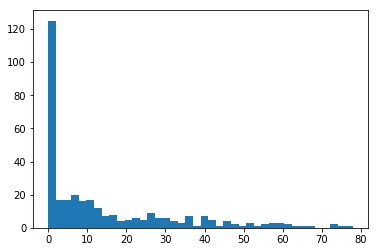

In [244]:
plt.hist(work2['기관확약'], bins =40)

In [245]:
work2.sort_values(by='기관확약')

,지분_주식매수선택권,지분_주간사락업,확정공모가,수요예측일,지분_미확약유통가능,주식_우리사주,상장전자본금,주식_일반공모,기관경쟁률,기관확약률,...,희석감안주식수,F01_시장구분,F02_코넥스,F03_중국,시가총액,F04_시가총액,상단,하단,F05_밴드대비,기관확약
코드,,,,,,,,,,,,,,,,,,,,,
053300,1.10,0.00,1800,2014-01-15,23.94,"540,000",107.83,"1,080,000",412.05 : 1,NaN,...,27265000,0.0,0.0,0.0,490.770000,1.0,1800,1600,4.0,0.00
147760,1.64,7.58,7300,2016-11-29,51.90,"300,000",43.21,"600,000",124.34 : 1,NaN,...,10909866,0.0,0.0,0.0,796.420218,1.0,8500,7300,2.0,0.00
176440,0.81,0.58,10000,2016-11-15,58.13,"135,000",27.70,"270,000",132.13 : 1,NaN,...,6986804,0.0,0.0,0.0,698.680400,1.0,16000,14000,1.0,0.00
204990,0.00,0.00,7000,2016-11-25,33.37,,100.00,"700,000",43.37 : 1,NaN,...,22175000,0.0,5.0,0.0,1552.250000,2.0,9000,7000,2.0,0.00
220180,3.21,0.00,5600,2016-11-08,37.76,"247,000",27.32,"380,000",262.22 : 1,NaN,...,7706009,0.0,5.0,0.0,431.536504,1.0,5600,4500,4.0,0.00
241560,0.00,0.00,30000,2016-11-04,23.96,"6,005,636",500.41,"6,005,636",9.81 : 1,10.20,...,100254913,5.0,0.0,0.0,30076.473900,5.0,33000,29000,3.0,0.00
138080,0.00,20.01,10000,2014-02-13,31.89,"100,000",22.01,"155,389",319.37 : 1,8.93,...,5179610,0.0,0.0,0.0,517.961000,1.0,9800,8500,5.0,0.00
234920,0.00,0.68,11000,2016-08-19,32.59,"70,000",56.00,"896,000",18.90 : 1,NaN,...,13530910,0.0,0.0,0.0,1488.400100,2.0,23000,20000,1.0,0.00
201490,3.45,2.43,3800,2016-09-21,47.06,,114.00,"1,432,142",73.09 : 1,NaN,...,31253943,0.0,0.0,0.0,1187.649834,2.0,4300,3800,2.0,0.00


In [246]:
work2.loc[work2['기관확약'] > 50, 'F06_기관확약'] = 5
work2.loc[work2['기관확약'] < 50, 'F06_기관확약'] = 4
work2.loc[work2['기관확약'] < 20, 'F06_기관확약'] = 3
work2.loc[work2['기관확약'] < 10, 'F06_기관확약'] = 2
work2.loc[work2['기관확약'] == 0, 'F06_기관확약'] = 1

In [247]:
work2['F06_기관확약'].value_counts()

2.0    112
1.0     84
4.0     71
3.0     48
5.0     21
Name: F06_기관확약, dtype: int64

## 최대주주 지분율(F07_최대주주)


In [248]:
work2['지분_최대주주']

코드
099750    35.39
307950    76.15
228760    27.41
299660    20.69
278280    59.77
263050    35.07
125210    60.63
238200    41.78
298690    44.38
299900    29.81
298380    32.40
290550    58.32
100790    66.67
270870    51.90
100590    64.28
302430    61.34
027360    67.08
179290    65.74
227100    42.65
192650    66.65
263020    44.84
299910    40.98
117730    18.68
053580    18.44
290660    28.94
290670    70.28
128540    71.93
268600    23.47
290120    73.50
290650    32.39
          ...  
112610    52.15
149980    48.12
124500    43.69
196490    28.23
065660    21.42
143540    23.39
191420    39.72
182690    55.32
189860    57.91
194480    30.99
192440    59.14
194510    18.14
192410    49.51
192400    33.10
192390    47.10
177830    18.36
004650    15.41
187270    55.58
090410    35.57
105550    28.50
160550    36.33
133820    37.40
041920    52.83
059120    21.36
027410    65.86
071850    23.58
108790    73.70
145720    44.89
138080    46.17
053300    42.42
Name: 지분_최대주주, Length

(array([ 5.,  5., 21., 22., 13., 20., 27., 29., 21., 29., 24., 20., 23.,
        25., 17., 11., 14.,  8.,  0.,  2.]),
 array([ 9.62 , 13.389, 17.158, 20.927, 24.696, 28.465, 32.234, 36.003,
        39.772, 43.541, 47.31 , 51.079, 54.848, 58.617, 62.386, 66.155,
        69.924, 73.693, 77.462, 81.231, 85.   ]),
 <a list of 20 Patch objects>)

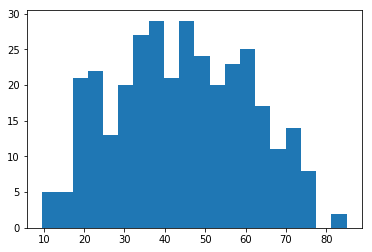

In [249]:
plt.hist(work2['지분_최대주주'], bins = 20)

In [250]:
# work2.loc[work2['지분_최대주주'] > 65, 'F07_최대주주'] = 5
# work2.loc[work2['지분_최대주주'] < 65, 'F07_최대주주'] = 4
# work2.loc[work2['지분_최대주주'] < 50, 'F07_최대주주'] = 3
# work2.loc[work2['지분_최대주주'] < 30, 'F07_최대주주'] = 2
# work2.loc[work2['지분_최대주주'] < 20, 'F07_최대주주'] = 1

# work2['F07_최대주주'].value_counts()




In [251]:
work2['지분_최대주주'].min()

9.62

In [252]:
work2['F07_최대주주'] = np.log(work2['지분_최대주주']*0.3)*2.0-1

(array([ 2.,  1.,  2.,  2.,  2.,  5., 14., 12., 17., 11., 15., 29., 28.,
        28., 35., 35., 39., 32., 25.,  2.]),
 array([1.11974292, 1.33762362, 1.55550432, 1.77338502, 1.99126572,
        2.20914642, 2.42702712, 2.64490781, 2.86278851, 3.08066921,
        3.29854991, 3.51643061, 3.73431131, 3.95219201, 4.17007271,
        4.38795341, 4.60583411, 4.82371481, 5.04159551, 5.25947621,
        5.4773569 ]),
 <a list of 20 Patch objects>)

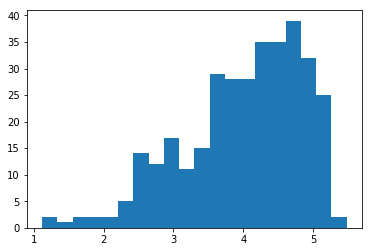

In [253]:
plt.hist(work2['F07_최대주주'], bins = 20)

## 미확약 유통물량(F08_유통물량)

(array([ 2.,  4.,  4., 15., 45., 25., 46., 25., 21., 27., 26., 18., 21.,
        19., 16.,  6.,  6.,  7.,  1.,  2.]),
 array([ 9.92 , 13.218, 16.516, 19.814, 23.112, 26.41 , 29.708, 33.006,
        36.304, 39.602, 42.9  , 46.198, 49.496, 52.794, 56.092, 59.39 ,
        62.688, 65.986, 69.284, 72.582, 75.88 ]),
 <a list of 20 Patch objects>)

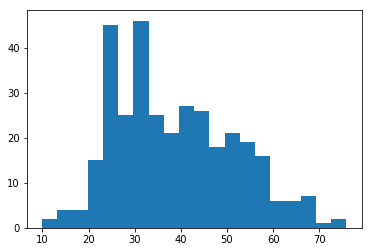

In [254]:
plt.hist(work2['지분_미확약유통가능'], bins = 20)

In [255]:
work2.loc[work2['지분_미확약유통가능'] > 60, 'F08_유통물량'] = 1
work2.loc[work2['지분_미확약유통가능'] < 60, 'F08_유통물량'] = 2
work2.loc[work2['지분_미확약유통가능'] < 50, 'F08_유통물량'] = 3
work2.loc[work2['지분_미확약유통가능'] < 35, 'F08_유통물량'] = 4
work2.loc[work2['지분_미확약유통가능'] < 20, 'F08_유통물량'] = 5

work2['F08_유통물량'].value_counts()

4.0    142
3.0    108
2.0     53
1.0     22
5.0     11
Name: F08_유통물량, dtype: int64

In [256]:
work2.loc[work2['종목명']=='링크제니시스', 'F08_유통물량']

코드
219420    2.0
Name: F08_유통물량, dtype: float64

## 미확약 오버행(F09_미확약오버행)

In [257]:
work2.loc['950170', '상장예정주식수'] = '24,580,225'
work2['상장예정주식수']

코드
099750      6,386,000
307950     21,000,000
228760     19,986,215
299660      9,446,889
278280     10,000,000
263050      7,263,578
125210     16,496,790
238200      4,090,000
298690     52,070,000
299900      8,798,060
298380     44,587,000
290550      6,879,982
100790     30,667,215
270870      9,100,084
100590     14,763,600
302430      4,825,108
027360    118,714,050
179290     30,423,558
227100      2,660,910
192650     27,585,500
263020      7,601,025
299910      7,980,271
117730      5,399,459
053580      6,630,322
290660     11,874,545
290670      3,232,600
128540     14,678,800
268600      7,612,607
290120     10,884,000
290650      7,234,332
             ...     
112610     17,285,715
149980      2,774,729
124500      4,311,520
196490      5,243,700
065660      7,463,435
143540      4,606,182
191420      3,560,000
182690     13,966,340
189860      4,849,390
194480     10,800,000
192440      6,224,444
194510      4,592,400
192410      2,406,800
192400      9,803,360
192390 

In [258]:
work2['희석감안주식수']

코드
099750      6386000
307950     21000000
228760     19986215
299660      9761889
278280     10000000
263050      7955056
125210     16496790
238200      4090000
298690     52070000
299900     10262551
298380     45303350
290550      8231333
100790     30907215
270870      9100084
100590     14763600
302430      4825108
027360    118714050
179290     30423558
227100      2715410
192650     31274628
263020      7763202
299910      8055271
117730      5779429
053580      6837394
290660     12209545
290670      3232600
128540     14678800
268600      8308107
290120     10884000
290650      7384332
            ...    
112610     17285715
149980      2876079
124500      4663075
196490      6043686
065660      7469635
143540      5584948
191420      3702857
182690     13966340
189860      4849390
194480     12053000
192440      6224444
194510      4770000
192410      2406800
192400      9803360
192390      6600300
177830      4941240
004650      7862730
187270      8051958
090410      80120

In [259]:
def to_int(text) :
    return int(text.replace(",", ""))

In [260]:
work2['상장예정주식수'] = work2['상장예정주식수'].apply(to_int)

In [261]:
work2['미확약주식비중'] = work2['희석감안주식수']/work2['상장예정주식수']*100-100

In [262]:
work2['미확약주식비중'] 

코드
099750     0.000000
307950     0.000000
228760     0.000000
299660     3.334431
278280     0.000000
263050     9.519799
125210     0.000000
238200     0.000000
298690     0.000000
299900    16.645613
298380     1.606634
290550    19.641781
100790     0.782595
270870     0.000000
100590     0.000000
302430     0.000000
027360     0.000000
179290     0.000000
227100     2.048171
192650    13.373432
263020     2.133620
299910     0.939818
117730     7.037187
053580     3.123106
290660     2.821161
290670     0.000000
128540     0.000000
268600     9.136161
290120     0.000000
290650     2.073446
            ...    
112610     0.000000
149980     3.652609
124500     8.153853
196490    15.256136
065660     0.083072
143540    21.248965
191420     4.012837
182690     0.000000
189860     0.000000
194480    11.601852
192440     0.000000
194510     3.867259
192410     0.000000
192400     0.000000
192390     0.000000
177830    21.019838
004650    27.326917
187270     7.747244
090410     0.0000

(array([228.,  28.,  20.,  15.,   7.,  14.,   7.,   3.,   3.,   2.,   2.,
          0.,   1.,   0.,   1.,   1.,   2.,   1.,   0.,   1.]),
 array([ 0.        ,  2.57866114,  5.15732228,  7.73598341, 10.31464455,
        12.89330569, 15.47196683, 18.05062796, 20.6292891 , 23.20795024,
        25.78661138, 28.36527251, 30.94393365, 33.52259479, 36.10125593,
        38.67991706, 41.2585782 , 43.83723934, 46.41590048, 48.99456161,
        51.57322275]),
 <a list of 20 Patch objects>)

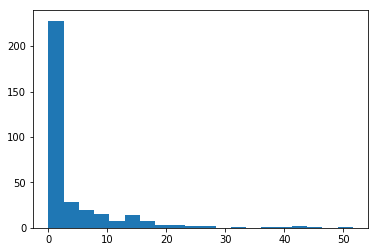

In [263]:
plt.hist(work2['미확약주식비중'], bins = 20)

In [264]:
work2.sort_values(by = '미확약주식비중')['종목명']

코드
099750        이지케어텍
900300     오가닉티코스메틱
900290     그레이트리치과기
238090         앤디포스
234080    제이더블유생명과학
208860     엔지스테크널러지
230360        에코마케팅
038160          팍스넷
229640     엘에스전선아시아
148250     알엔투테크놀로지
174880         장원테크
071460        대유위니아
900280        골든센츄리
237750        피앤씨테크
123890       한국자산신탁
144510        녹십자랩셀
195870        해성디에스
070960        용평리조트
228340         동양파일
228850         레이언스
004440       대림씨엔에스
226320         잇츠스킨
191410       육일씨엔에쓰
142210        유니트론텍
109610       에스와이패널
222980        한국맥널티
950140        잉글우드랩
122640          예스티
111110         호전실업
072990        에이치시티
            ...    
215600          신라젠
073560      우리손에프앤지
123010          옵토팩
196490     디에이테크놀로지
200670         휴메딕스
221610        한솔씨앤피
247540       에코프로비엠
900340         윙입푸드
299900      위지윅스튜디오
122310         제노레이
105550          트루윈
206560          덱스터
190510          나무가
085620       미래에셋생명
290550         디케이티
180400         엠지메드
177830         파버나인
143540       영우디에스피
064510       에코마이

In [265]:
work2.loc[work2['미확약주식비중'] > 30, 'F09_미확약오버행'] = 1
work2.loc[work2['미확약주식비중'] < 30, 'F09_미확약오버행'] = 2
work2.loc[work2['미확약주식비중'] < 15, 'F09_미확약오버행'] = 3
work2.loc[work2['미확약주식비중'] < 5, 'F09_미확약오버행'] = 4
work2.loc[work2['미확약주식비중'] == 0, 'F09_미확약오버행'] = 5

In [266]:
work2['F09_미확약오버행'].value_counts()

5.0    177
4.0     79
3.0     49
2.0     24
1.0      7
Name: F09_미확약오버행, dtype: int64

## 단기 오버행(F10_단기오버행)

* 1개월 또는 2주 미만 오버행 계산


In [267]:
work2['락업_1개월']

코드
099750     0.00
307950     0.00
228760    27.50
299660    11.69
278280     0.00
263050     3.47
125210     1.79
238200    12.13
298690     0.00
299900     8.57
298380     3.86
290550    11.07
100790     0.00
270870     0.00
100590     0.00
302430     0.12
027360     0.00
179290     3.90
227100    13.48
192650     0.00
263020     0.00
299910    12.65
117730     9.32
053580     0.00
290660    14.72
290670     0.00
128540     0.00
268600     3.05
290120     0.00
290650    14.27
          ...  
112610     0.00
149980     0.00
124500     0.00
196490    13.23
065660     2.63
143540    10.52
191420     3.86
182690     0.00
189860     0.00
194480     1.62
192440     0.00
194510    10.00
192410     8.31
192400     0.00
192390     0.00
177830     8.20
004650     7.85
187270     7.19
090410     0.00
105550     0.54
160550    10.55
133820     5.38
041920     0.00
059120     0.00
027410     0.00
071850     1.98
108790     0.00
145720     0.00
138080    20.01
053300     0.00
Name: 락업_1개월, Length:

(array([204.,  21.,  15.,  10.,  13.,  16.,  26.,  10.,   6.,   5.,   3.,
          1.,   1.,   0.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([ 0.   ,  1.564,  3.128,  4.692,  6.256,  7.82 ,  9.384, 10.948,
        12.512, 14.076, 15.64 , 17.204, 18.768, 20.332, 21.896, 23.46 ,
        25.024, 26.588, 28.152, 29.716, 31.28 ]),
 <a list of 20 Patch objects>)

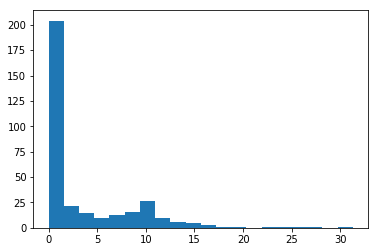

In [268]:
plt.hist(work2['락업_1개월'], bins = 20)

In [269]:
work2.loc[work2['미확약주식비중'] > 15, 'F10_단기오버행'] = 1
work2.loc[work2['미확약주식비중'] < 15, 'F10_단기오버행'] = 2
work2.loc[work2['미확약주식비중'] < 10, 'F10_단기오버행'] = 3
work2.loc[work2['미확약주식비중'] < 5, 'F10_단기오버행'] = 4
work2.loc[work2['미확약주식비중'] == 0, 'F10_단기오버행'] = 5

(array([ 31.,  15.,  34.,  79., 177.]),
 array([1. , 1.8, 2.6, 3.4, 4.2, 5. ]),
 <a list of 5 Patch objects>)

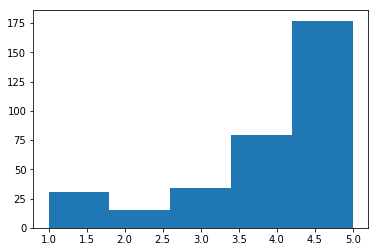

In [270]:
plt.hist(work2['F10_단기오버행'], bins = 5)

## 상장월(F11_상장월)


In [271]:
work2['상장일'] = pd.to_datetime(work2['상장일'])

In [272]:
work2['상장일'].dt.month

코드
099750     3
307950     3
228760     3
299660     2
278280     2
263050    12
125210     3
238200    12
298690    12
299900    12
298380    12
290550    12
100790     3
270870    12
100590    12
302430    12
027360    11
179290    11
227100    11
192650     3
263020    11
299910    12
117730    11
053580     1
290660    11
290670    11
128540    12
268600    11
290120    12
290650    11
          ..
112610    11
149980    12
124500    12
196490    11
065660     2
143540    10
191420    11
182690    10
189860    12
194480    10
192440    11
194510    11
192410     8
192400     8
192390     7
177830     8
004650     7
187270     8
090410     8
105550     7
160550    12
133820     7
041920    10
059120     7
027410     5
071850     5
108790     2
145720     3
138080     2
053300     2
Name: 상장일, Length: 336, dtype: int64

(array([ 33.,  21.,   8.,   9.,  23.,  32.,  30.,  22.,  32., 126.]),
 array([ 1. ,  2.1,  3.2,  4.3,  5.4,  6.5,  7.6,  8.7,  9.8, 10.9, 12. ]),
 <a list of 10 Patch objects>)

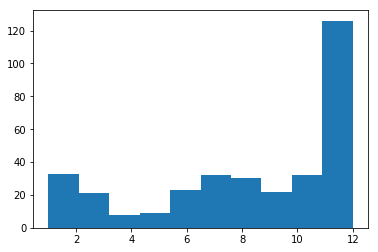

In [273]:
plt.hist(work2['상장일'].dt.month)

In [274]:
month_df = pd.get_dummies(work2['상장일'].dt.month, prefix = 'F11_상장월') 
month_df

,F11_상장월_1,F11_상장월_2,F11_상장월_3,F11_상장월_4,F11_상장월_5,F11_상장월_6,F11_상장월_7,F11_상장월_8,F11_상장월_9,F11_상장월_10,F11_상장월_11,F11_상장월_12
코드,,,,,,,,,,,,
099750,0,0,1,0,0,0,0,0,0,0,0,0
307950,0,0,1,0,0,0,0,0,0,0,0,0
228760,0,0,1,0,0,0,0,0,0,0,0,0
299660,0,1,0,0,0,0,0,0,0,0,0,0
278280,0,1,0,0,0,0,0,0,0,0,0,0
263050,0,0,0,0,0,0,0,0,0,0,0,1
125210,0,0,1,0,0,0,0,0,0,0,0,0
238200,0,0,0,0,0,0,0,0,0,0,0,1
298690,0,0,0,0,0,0,0,0,0,0,0,1


In [275]:
work3 = pd.concat([work2, month_df], axis =1 , join_axes=[work2.index] )

In [276]:
work3

,지분_주식매수선택권,지분_주간사락업,확정공모가,수요예측일,지분_미확약유통가능,주식_우리사주,상장전자본금,주식_일반공모,기관경쟁률,기관확약률,...,F11_상장월_3,F11_상장월_4,F11_상장월_5,F11_상장월_6,F11_상장월_7,F11_상장월_8,F11_상장월_9,F11_상장월_10,F11_상장월_11,F11_상장월_12
코드,,,,,,,,,,,,,,,,,,,,,
099750,0.00,0.61,12300,2019-03-06,56.66,"150,000",25.24,"260,000","1,108.03 : 1",NaN,...,1,0,0,0,0,0,0,0,0,0
307950,0.00,7.14,48000,2019-03-14,13.37,"702,000",103.26,"702,000",797.36 : 1,NaN,...,1,0,0,0,0,0,0,0,0,0
228760,0.00,34.05,27000,2019-03-12,37.94,"120,000",79.75,"800,000",372.39 : 1,NaN,...,1,0,0,0,0,0,0,0,0,0
299660,3.23,12.06,33000,2019-01-30,46.51,"9,270",41.05,"240,000",778.77 : 1,NaN,...,0,0,0,0,0,0,0,0,0,0
278280,0.00,0.00,40000,2019-01-22,35.68,"250,000",40.00,"500,000",891.09 : 1,NaN,...,0,0,0,0,0,0,0,0,0,0
263050,8.69,3.72,50000,2018-12-11,36.61,"43,620",32.58,"145,400",597.20 : 1,NaN,...,0,0,0,0,0,0,0,0,0,1
125210,0.00,2.40,9900,2019-03-13,35.72,"206,400",65.47,"825,600",164.22 : 1,3.05,...,1,0,0,0,0,0,0,0,0,0
238200,0.00,12.43,18000,2018-12-12,44.45,"19,400",18.34,"82,001",74.62 : 1,NaN,...,0,0,0,0,0,0,0,0,0,1
298690,0.00,0.00,3600,2018-12-14,53.62,"1,041,400",500.00,"1,041,400",23.89 : 1,0.00,...,0,0,0,0,0,0,0,0,0,1


In [277]:
work3[work3['종목명'] == '링크제니시스']['F08_유통물량']

코드
219420    2.0
Name: F08_유통물량, dtype: float64

## 집중도(F12_해당월)

In [278]:
mc_df = work3.set_index('상장일').groupby(pd.Grouper(freq='M'))['종목명'].count()

In [279]:
mc_df = pd.DataFrame(mc_df).reset_index()

In [280]:
mc_df['new_dt'] = mc_df['상장일'].apply(lambda x : datetime.strftime(x, '%Y-%m'))

In [281]:
mc_df

,상장일,종목명,new_dt
0,2014-02-28,3,2014-02
1,2014-03-31,0,2014-03
2,2014-04-30,0,2014-04
3,2014-05-31,2,2014-05
4,2014-06-30,0,2014-06
5,2014-07-31,5,2014-07
6,2014-08-31,5,2014-08
7,2014-09-30,0,2014-09
8,2014-10-31,4,2014-10
9,2014-11-30,7,2014-11


In [282]:
work3['상장월'] = work3['상장일'].apply(lambda x : datetime.strftime(x, '%Y-%m'))

In [283]:
def find_month_count(text) : 
    return mc_df.loc[mc_df['new_dt']==text, '종목명'].values[0]

In [284]:
work3['상장월'].apply(find_month_count)

코드
099750     7
307950     7
228760     7
299660     3
278280     3
263050    13
125210     7
238200    13
298690    13
299900    13
298380    13
290550    13
100790     7
270870    13
100590    13
302430    13
027360    18
179290    18
227100    18
192650     7
263020    18
299910    13
117730    18
053580     2
290660    18
290670    18
128540    13
268600    18
290120    13
290650    18
          ..
112610     7
149980    20
124500    20
196490     7
065660     5
143540     4
191420     7
182690     4
189860    20
194480     4
192440     7
194510     7
192410     5
192400     5
192390     5
177830     5
004650     5
187270     5
090410     5
105550     5
160550    20
133820     5
041920     4
059120     5
027410     2
071850     2
108790     3
145720     5
138080     3
053300     3
Name: 상장월, Length: 336, dtype: int64

In [285]:
work3['F12_해당월'] = work3['상장월'].apply(find_month_count)

(array([ 4., 18., 24., 28., 45.,  6., 21., 32., 27., 10., 22.,  0., 26.,
         0., 15.,  0.,  0., 18.,  0., 40.]),
 array([ 1.  ,  1.95,  2.9 ,  3.85,  4.8 ,  5.75,  6.7 ,  7.65,  8.6 ,
         9.55, 10.5 , 11.45, 12.4 , 13.35, 14.3 , 15.25, 16.2 , 17.15,
        18.1 , 19.05, 20.  ]),
 <a list of 20 Patch objects>)

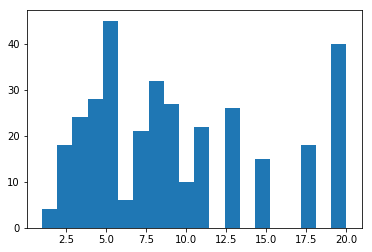

In [286]:
plt.hist(work3['F12_해당월'], bins = 20)

In [287]:
work3['F12_해당월'] = np.log(work3['F12_해당월'])*5/3

(array([ 4.,  0., 18., 24., 28., 51., 53., 37., 48., 73.]),
 array([0.        , 0.49928871, 0.99857742, 1.49786614, 1.99715485,
        2.49644356, 2.99573227, 3.49502099, 3.9943097 , 4.49359841,
        4.99288712]),
 <a list of 10 Patch objects>)

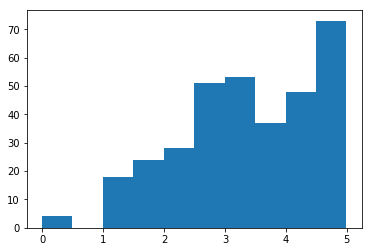

In [288]:
plt.hist(work3['F12_해당월'], bins = 10)

## 직전달  수익률(F13_직전수익률)

* 수익률 데이터를 불러와야 함

## 시초가(P1_시초가)


## 상장일 종가(P2_상장종가)


## 공모가대비 시초가(P3_시초Rate)


## 시초가대비 종가(P4_종가Rate)


#### 수익률 데이터 불러오기

In [289]:
url = "http://www.38.co.kr/html/fund/index.htm?o=nw&page=1"
pdf = pd.read_html(url)

In [290]:
pdf[15][['기업명','시초가(원)','첫날종가(원)']].dropna()


,기업명,시초가(원),첫날종가(원)
0,에스앤케이,-,예정
1,하이스팩4호,-,예정
2,아모그린텍,10300,10200
3,현대오토에버(유가),75500,88700
4,케이비스팩17호,1995,2000
5,지노믹트리,29450,27300
6,이지케어텍,24600,31950
7,유안타스팩4호,2005,2000
8,미래에셋벤처투자,6150,5310
9,드림텍(유가),17350,15400


#### 38 사이트에서 데이터 가져오기

In [291]:
pm_df = pd.DataFrame()
for i in progressbar(range(1,26)) :
    url = "http://www.38.co.kr/html/fund/index.htm?o=nw&page=" + str(i)
    pdf = pd.read_html(url)
    pdf = pdf[15]
    pm_df = pm_df.append(pdf[['기업명','시초가(원)','첫날종가(원)']].dropna())
    time.sleep(random.randint(5,10)/10)
    

100% (25 of 25) |########################| Elapsed Time: 0:00:24 Time:  0:00:24


In [292]:
pm_df = pm_df[pm_df['기업명'].str.len() < 25]

In [293]:
def make_name(text) :
    return text.split("(")[0]

In [294]:
pm_df['기업명'] = pm_df['기업명'].apply(make_name)

In [295]:
pm_df

,기업명,시초가(원),첫날종가(원)
0,에스앤케이,-,예정
1,하이스팩4호,-,예정
2,아모그린텍,10300,10200
3,현대오토에버,75500,88700
4,케이비스팩17호,1995,2000
5,지노믹트리,29450,27300
6,이지케어텍,24600,31950
7,유안타스팩4호,2005,2000
8,미래에셋벤처투자,6150,5310
9,드림텍,17350,15400


In [296]:
pm_df = pm_df.replace('제이티씨', 'JTC')
pm_df = pm_df.replace('컬러레이', '컬러레이홀딩스')
pm_df = pm_df.replace('엘앤케이바이오', '엘앤케이바이오메드')
pm_df = pm_df.replace('금세기차륜', '골든센츄리')
pm_df = pm_df.replace('미래에셋생명보험', '미래에셋생명')
pm_df = pm_df.replace('아시아경제신문사', '아시아경제')
pm_df = pm_df.replace('에프엔씨엔터테인먼트', 'FNC엔터테인먼트')
pm_df = pm_df.replace('아주IB투자', '아주아이비투자')

pm_df

,기업명,시초가(원),첫날종가(원)
0,에스앤케이,-,예정
1,하이스팩4호,-,예정
2,아모그린텍,10300,10200
3,현대오토에버,75500,88700
4,케이비스팩17호,1995,2000
5,지노믹트리,29450,27300
6,이지케어텍,24600,31950
7,유안타스팩4호,2005,2000
8,미래에셋벤처투자,6150,5310
9,드림텍,17350,15400


In [297]:
pm_df[pm_df['기업명'] =='지티지웰니스']

,기업명,시초가(원),첫날종가(원)
7,지티지웰니스,15250,-


#### 잘못된 데이터에 대해서는 수정작업

In [298]:
pm_df.loc[pm_df['기업명'] == '유티아이', '첫날종가(원)'] = '18650'
pm_df.loc[pm_df['기업명'] == '신흥에스이씨', '첫날종가(원)'] = '20850'
pm_df.loc[pm_df['기업명'] == '아이콘트롤스', '첫날종가(원)'] = '33250'
pm_df.loc[pm_df['기업명'] == '동일제강', '첫날종가(원)'] = '3195'
pm_df.loc[pm_df['기업명'] =='지티지웰니스', '첫날종가(원)'] = '14150'

pm_df.loc[pm_df['기업명'] == '상신전자', '시초가(원)'] = '16950'
pm_df.loc[pm_df['기업명'] == '아이엠텍', '시초가(원)'] = '9500'
pm_df.loc[pm_df['기업명'] == '코미코', '시초가(원)'] = '26000'
pm_df.loc[pm_df['기업명'] == '알엔투테크놀로지', '시초가(원)'] = '12500'



In [299]:
def find_open_price(company) :
    return int(pm_df.loc[pm_df['기업명'] == company, '시초가(원)'].values[0])

In [300]:
def find_close_price(company) :
    return int(pm_df.loc[pm_df['기업명'] == company, '첫날종가(원)'].values[0])

In [301]:
for i in work3['종목명'].tolist() :
    print(i)
    print(find_open_price(i))
    print(find_close_price(i))

이지케어텍
24600
31950
현대오토에버
75500
88700
지노믹트리
29450
27300
셀리드
43750
51100
천보
52500
47650
유틸렉스
60100
78100
아모그린텍
10300
10200
비피도
36000
36500
에어부산
4020
5220
위지윅스튜디오
11250
9350
에이비엘바이오
13500
13650
디케이티
12900
10550
미래에셋벤처투자
6150
5310
뉴트리
13050
13900
머큐리
9630
7800
이노메트리
40000
29550
아주아이비투자
1350
1150
엠아이텍
4050
4770
디자인
20200
15200
드림텍
17350
15400
디케이앤디
7570
6230
베스파
33400
30000
티로보틱스
14400
13050
웹케시
31700
28500
네오펙트
9900
7700
대보마그네틱
60200
58500
에코캡
4100
5330
셀리버리
32000
28700
대유에이피
6000
4935
엘앤씨바이오
29800
26950
디알젬
8470
6760
하나제약
30100
33150
푸드나무
43350
34000
나우아이비캐피탈
9300
7180
옵티팜
9000
11700
로보티즈
28000
19600
디지캡
13250
10900
아시아나IDT
14300
12450
오파스넷
18000
14200
지티지웰니스
15250
14150
크리스에프앤씨
27000
24000
노바텍
14100
18300
액트로
20700
18000
노바렉스
25450
20100
남화산업
5610
7290
전진바이오팜
11550
12750
대유
13250
12400
에스퓨얼셀
33000
33800
바이오솔루션
28200
28500
우진아이엔에스
15150
19650
티웨이항공
11600
11550
한국유니온제약
23000
19500
디아이티
10550
10650
엠코르셋
11050
12950
휴네시온
15000
16350
에스에스알
18000
23400
올릭스
72000
65600
에스브이인베스트먼트
9000
7710
에코프로

In [302]:
work3['P1_시초가'] = work3['종목명'].apply(find_open_price)

In [303]:
work3['P2_상장일종가'] = work3['종목명'].apply(find_close_price)

In [304]:
work3['P3_시초Rate'] = round((work3['P1_시초가']/work3['확정공모가']- 1)*100,1)

In [305]:
work3['P4_종가Rate'] = round((work3['P2_상장일종가']/work3['P1_시초가'] - 1)*100,1)

(array([61., 40., 24., 22., 16., 19., 17., 14.,  6., 12., 15., 14.,  8.,
         8.,  7.,  4.,  3., 45.,  0.,  1.]),
 array([-10.7 ,  -4.39,   1.92,   8.23,  14.54,  20.85,  27.16,  33.47,
         39.78,  46.09,  52.4 ,  58.71,  65.02,  71.33,  77.64,  83.95,
         90.26,  96.57, 102.88, 109.19, 115.5 ]),
 <a list of 20 Patch objects>)

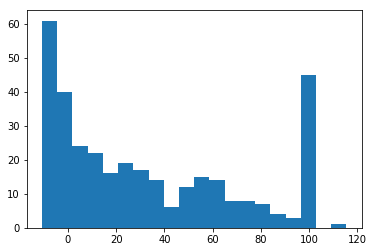

In [306]:
plt.hist(work3['P3_시초Rate'], bins = 20)

In [307]:
work3.loc[work3['종목명']=='알엔투테크놀로지', '확정공모가']

코드
148250    5800
Name: 확정공모가, dtype: int64

(array([ 9.,  9., 12., 12., 24., 41., 32., 19., 16., 20., 21., 16.,  7.,
         8., 11., 23.,  4.,  1.,  1., 50.]),
 array([-30., -27., -24., -21., -18., -15., -12.,  -9.,  -6.,  -3.,   0.,
          3.,   6.,   9.,  12.,  15.,  18.,  21.,  24.,  27.,  30.]),
 <a list of 20 Patch objects>)

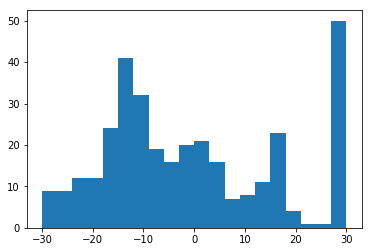

In [308]:
plt.hist(work3['P4_종가Rate'], bins = 20)

## 직전딜  수익률(F13_직전수익률)

* 최근 5개 딜의 수익률 평균

In [309]:
work3['공모가대비_종가'] = round((work3['P2_상장일종가'] / work3['확정공모가']- 1)*100,1)

In [310]:
work3['F13_직전수익률'] = work3['공모가대비_종가'].rolling(5).mean().fillna(0)

In [311]:
work3['F13_직전수익률'] = (np.log(work3['F13_직전수익률']+30) - 2.5)*2.2

(array([ 1.,  1.,  5., 13., 47., 82., 63., 68., 49.,  7.]),
 array([-0.23666325,  0.33357728,  0.90381781,  1.47405834,  2.04429887,
         2.6145394 ,  3.18477993,  3.75502046,  4.32526099,  4.89550152,
         5.46574204]),
 <a list of 10 Patch objects>)

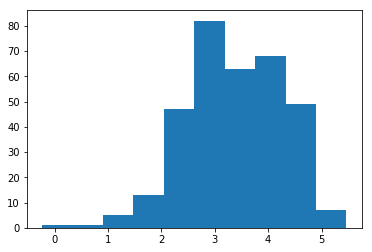

In [312]:
plt.hist(work3['F13_직전수익률'])

## 기관 경쟁률(F14_기관경쟁률)


In [313]:
def rate_to_float(rate) :
    return float(rate.replace(',','').split(':')[0])

In [314]:
work3['기관경쟁률_num'] = work3['기관경쟁률'].apply(rate_to_float)

(array([113.,  39.,  35.,  34.,  21.,  37.,  29.,  14.,  13.,   1.]),
 array([   3.77 ,  114.196,  224.622,  335.048,  445.474,  555.9  ,
         666.326,  776.752,  887.178,  997.604, 1108.03 ]),
 <a list of 10 Patch objects>)

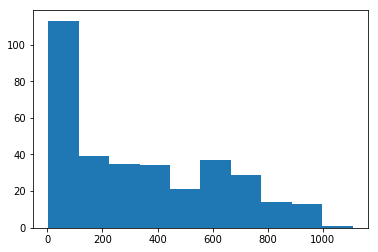

In [315]:
plt.hist(work3['기관경쟁률_num'])

In [316]:
work3.loc[work3['기관경쟁률_num'] > 500, 'F14_기관경쟁률'] = 5
work3.loc[work3['기관경쟁률_num'] < 500, 'F14_기관경쟁률'] = 4
work3.loc[work3['기관경쟁률_num'] < 300, 'F14_기관경쟁률'] = 3
work3.loc[work3['기관경쟁률_num'] < 150, 'F14_기관경쟁률'] = 2
work3.loc[work3['기관경쟁률_num'] < 50, 'F14_기관경쟁률'] = 1

work3['F14_기관경쟁률'].value_counts()

5.0    104
1.0     67
2.0     61
4.0     53
3.0     51
Name: F14_기관경쟁률, dtype: int64

## 일반공모 경쟁률(F15_공모경쟁률)

In [317]:
work3['공모경쟁률_num'] = work3['일반경쟁률'].apply(rate_to_float)

(array([114.,  46.,  32.,  35.,  39.,  31.,  25.,   8.,   5.,   1.]),
 array([2.900000e-01, 1.692610e+02, 3.382320e+02, 5.072030e+02,
        6.761740e+02, 8.451450e+02, 1.014116e+03, 1.183087e+03,
        1.352058e+03, 1.521029e+03, 1.690000e+03]),
 <a list of 10 Patch objects>)

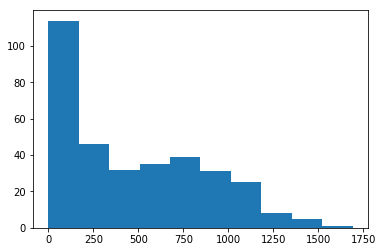

In [318]:
plt.hist(work3['공모경쟁률_num'])

In [319]:
work3.loc[work3['공모경쟁률_num'] > 500, 'F15_공모경쟁률'] = 5
work3.loc[work3['공모경쟁률_num'] < 500, 'F15_공모경쟁률'] = 4
work3.loc[work3['공모경쟁률_num'] < 300, 'F15_공모경쟁률'] = 3
work3.loc[work3['공모경쟁률_num'] < 150, 'F15_공모경쟁률'] = 2
work3.loc[work3['공모경쟁률_num'] < 50, 'F15_공모경쟁률'] = 1

work3['F15_공모경쟁률'].value_counts()

5.0    146
1.0     91
4.0     41
3.0     38
2.0     20
Name: F15_공모경쟁률, dtype: int64

### IPO 주가 예측해 보기

In [320]:
F_col = ['종목명', '확정공모가','상장일']  + list(work3.columns[work3.columns.str.contains("F")]) + ['P3_시초Rate', 'P4_종가Rate']

In [321]:
work3[F_col]

,종목명,확정공모가,상장일,F01_시장구분,F02_코넥스,F03_중국,F04_시가총액,F05_밴드대비,F06_기관확약,F07_최대주주,...,F11_상장월_9,F11_상장월_10,F11_상장월_11,F11_상장월_12,F12_해당월,F13_직전수익률,F14_기관경쟁률,F15_공모경쟁률,P3_시초Rate,P4_종가Rate
코드,,,,,,,,,,,,,,,,,,,,,
099750,이지케어텍,12300,2019-03-22,0.0,0.0,0.0,1.0,4.0,4.0,3.724913,...,0,0,0,0,3.243184,1.982634,5.0,5.0,100.0,29.9
307950,현대오토에버,48000,2019-03-28,5.0,0.0,0.0,5.0,5.0,5.0,5.257465,...,0,0,0,0,3.243184,1.982634,5.0,4.0,57.3,17.5
228760,지노믹트리,27000,2019-03-27,0.0,5.0,0.0,4.0,5.0,4.0,3.213870,...,0,0,0,0,3.243184,1.982634,4.0,1.0,9.1,-7.3
299660,셀리드,33000,2019-02-20,0.0,0.0,0.0,3.0,5.0,3.0,2.651355,...,0,0,0,0,1.831020,1.982634,5.0,5.0,32.6,16.8
278280,천보,40000,2019-02-11,0.0,0.0,0.0,4.0,4.0,3.0,4.773062,...,0,0,0,0,1.831020,4.493375,5.0,4.0,31.2,-9.2
263050,유틸렉스,50000,2018-12-24,0.0,0.0,0.0,3.0,4.0,3.0,3.706747,...,0,0,0,1,4.274916,3.945030,5.0,4.0,20.2,30.0
125210,아모그린텍,9900,2019-03-29,0.0,0.0,0.0,2.0,4.0,2.0,4.801634,...,0,0,0,0,3.243184,3.388529,3.0,1.0,4.0,-1.0
238200,비피도,18000,2018-12-26,0.0,0.0,0.0,1.0,1.0,1.0,4.056890,...,0,0,0,1,4.274916,4.061509,2.0,3.0,100.0,1.4
298690,에어부산,3600,2018-12-27,5.0,0.0,0.0,2.0,2.0,2.0,4.177632,...,0,0,0,1,4.274916,4.004918,1.0,1.0,11.7,29.9


In [322]:
work3[F_col].isna().sum()

종목명           0
확정공모가         0
상장일           0
F01_시장구분      0
F02_코넥스       0
F03_중국        0
F04_시가총액      0
F05_밴드대비      0
F06_기관확약      0
F07_최대주주      0
F08_유통물량      0
F09_미확약오버행    0
F10_단기오버행     0
F11_상장월_1     0
F11_상장월_2     0
F11_상장월_3     0
F11_상장월_4     0
F11_상장월_5     0
F11_상장월_6     0
F11_상장월_7     0
F11_상장월_8     0
F11_상장월_9     0
F11_상장월_10    0
F11_상장월_11    0
F11_상장월_12    0
F12_해당월       0
F13_직전수익률     0
F14_기관경쟁률     0
F15_공모경쟁률     0
P3_시초Rate     0
P4_종가Rate     0
dtype: int64

(array([18., 24., 65., 51., 36., 37., 15., 34.,  5., 51.]),
 array([-30., -24., -18., -12.,  -6.,   0.,   6.,  12.,  18.,  24.,  30.]),
 <a list of 10 Patch objects>)

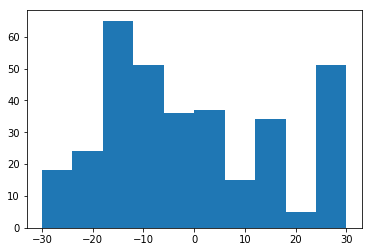

In [323]:
plt.hist(work3['P4_종가Rate'])

#### 필요한 주가 데이터 불러오기

In [324]:
import seaborn as sns

In [325]:
work3[['공모경쟁률_num', 'P3_시초Rate']].corr()

,공모경쟁률_num,P3_시초Rate
공모경쟁률_num,1.000000,0.593409
P3_시초Rate,0.593409,1.000000


In [326]:
work3[['P3_시초Rate','P4_종가Rate','공모경쟁률_num', '기관경쟁률_num', 'F09_미확약오버행', 'F07_최대주주', 'F08_유통물량', 'F01_시장구분']].corr()

,P3_시초Rate,P4_종가Rate,공모경쟁률_num,기관경쟁률_num,F09_미확약오버행,F07_최대주주,F08_유통물량,F01_시장구분
P3_시초Rate,1.000000,0.018415,0.593409,0.542239,-0.097397,0.016765,0.123888,-0.183592
P4_종가Rate,0.018415,1.000000,-0.110619,0.016434,0.009114,0.096013,0.079401,0.065616
공모경쟁률_num,0.593409,-0.110619,1.000000,0.696407,-0.121977,-0.064715,0.035635,-0.268387
기관경쟁률_num,0.542239,0.016434,0.696407,1.000000,-0.126579,0.003493,0.047389,-0.209894
F09_미확약오버행,-0.097397,0.009114,-0.121977,-0.126579,1.000000,0.364006,0.120294,0.166329
F07_최대주주,0.016765,0.096013,-0.064715,0.003493,0.364006,1.000000,0.657791,0.212502
F08_유통물량,0.123888,0.079401,0.035635,0.047389,0.120294,0.657791,1.000000,0.226363
F01_시장구분,-0.183592,0.065616,-0.268387,-0.209894,0.166329,0.212502,0.226363,1.000000


In [327]:
mat_col = ['P3_시초Rate', 'P4_종가Rate'] + list(work3.columns[work3.columns.str.contains("F")]) 

In [328]:
re_df = work3[mat_col].corr()

In [329]:
re_df['P3_시초Rate']

P3_시초Rate     1.000000
P4_종가Rate     0.018415
F01_시장구분     -0.183592
F02_코넥스      -0.080426
F03_중국       -0.060929
F04_시가총액     -0.236197
F05_밴드대비      0.406719
F06_기관확약      0.398137
F07_최대주주      0.016765
F08_유통물량      0.123888
F09_미확약오버행   -0.097397
F10_단기오버행    -0.095868
F11_상장월_1    -0.053631
F11_상장월_2     0.136498
F11_상장월_3     0.034056
F11_상장월_4     0.010144
F11_상장월_5     0.061758
F11_상장월_6     0.109012
F11_상장월_7     0.019766
F11_상장월_8     0.105852
F11_상장월_9    -0.098952
F11_상장월_10   -0.055358
F11_상장월_11   -0.139231
F11_상장월_12   -0.047152
F12_해당월      -0.133675
F13_직전수익률     0.425886
F14_기관경쟁률     0.510638
F15_공모경쟁률     0.547803
Name: P3_시초Rate, dtype: float64

In [330]:
cdf = work3[F_col]

In [331]:
cdf = cdf.reset_index()

In [332]:
cdf['코드'] = "A" + cdf['코드']

In [333]:
cdf.to_csv('IPO_Factors.csv', encoding = 'euckr')

### 상장일 데이터 저장하기

In [334]:
def make_code(code) :
    return "A" + code

In [335]:
date_data = work3.copy

In [336]:
date_data = work3[['종목명', '상장일']]

In [337]:
date_data = date_data.reset_index()

In [338]:
date_data['코드'] = date_data['코드'].apply(make_code)

In [339]:
date_data.to_csv('IPO상장일.csv', encoding = 'euckr')